# Prelab5

### import all needed libraries

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

### load images

In [2]:
dp_l = cv.cvtColor(cv.imread('daft_punk_left.jpg'),cv.COLOR_RGB2BGR)
dp_r = cv.cvtColor(cv.imread('daft_punk_right.jpg'),cv.COLOR_RGB2BGR)
cmp_l = cv.imread('computers_left.png')
cmp_r = cv.imread('computers_right.png')


cmp_l_gray = cv.cvtColor(cmp_l,cv.COLOR_BGR2GRAY)
cmp_r_gray = cv.cvtColor(cmp_r,cv.COLOR_BGR2GRAY)
dp_l_gray = cv.cvtColor(dp_l,cv.COLOR_BGR2GRAY)
dp_r_gray = cv.cvtColor(dp_r,cv.COLOR_BGR2GRAY)

### 1.1 Feature Matching

<Figure size 1800x1200 with 0 Axes>

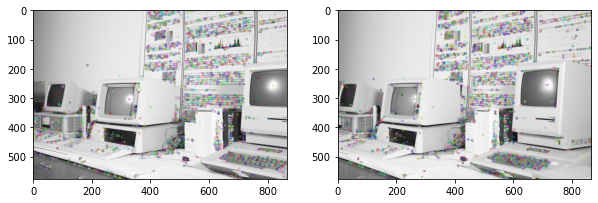

In [3]:
# SIFT
my_SIFT_instance = cv.SIFT_create()
mask = None
[kps_cmp_l,dps_cmp_l] = my_SIFT_instance.detectAndCompute(cmp_l_gray,mask)
[kps_cmp_r,dps_cmp_r] = my_SIFT_instance.detectAndCompute(cmp_r_gray,mask)
[kps_dp_l,dps_dp_l] = my_SIFT_instance.detectAndCompute(dp_l_gray,mask)
[kps_dp_r,dps_dp_r] = my_SIFT_instance.detectAndCompute(dp_r_gray,mask)

# Matcher
bf = cv.FlannBasedMatcher(dict(algorithm = 0, trees = 5), dict(checks = 50) )
cmp_matches = bf.knnMatch(dps_cmp_l,dps_cmp_r, k=2)
dp_matches = bf.knnMatch(dps_dp_l,dps_dp_r, k=2)
match = cv.drawMatchesKnn(dp_l_gray, kps_dp_l, dp_r_gray, kps_dp_r, dp_matches, None, flags=0)

# Lowe's Ratio's matches
def LoweRatioTest(match):  
    good_distance = []
    distance = []
    ratio_match = []
    query = []
    train = []
    for m,n in match:
        distance.append(m.distance)
        ratio = (m.distance)/(n.distance)
        if ratio < 0.8:
            ratio_match.append([m])
            query.append(m.queryIdx)
            good_distance.append(m.distance)
            train.append(m.trainIdx)
    return ratio_match,good_distance,distance,query,train

plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
cmp_l_gray = cv.drawKeypoints(cmp_l_gray,kps_cmp_l,cmp_l_gray)
plt.imshow(cmp_l_gray,cmap="gray")
plt.subplot(1,2,2)
cmp_r_gray = cv.drawKeypoints(cmp_r_gray,kps_cmp_r,cmp_r_gray)
plt.imshow(cmp_r_gray,cmap="gray")

### 1.2 Epipolar Lines Calculation 

<Figure size 1800x1200 with 0 Axes>

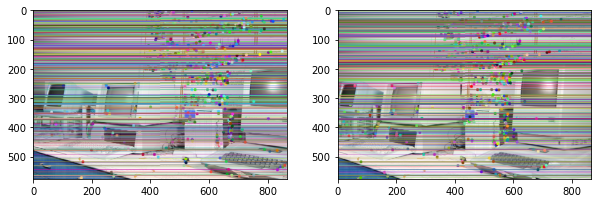

<Figure size 1800x1200 with 0 Axes>

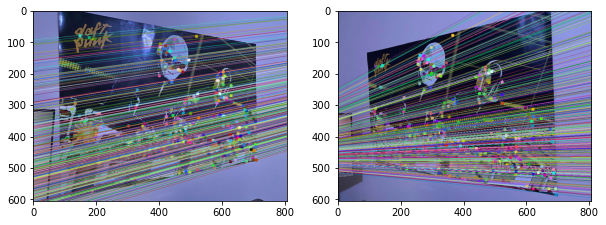

In [4]:
def DrawLine(pic, temp, lp, rp, check): 
    x = pic.shape[1]
    result = np.copy(pic)
    red = (0,0,255)
    for line, y in zip(temp, lp):
        line = line[0]
        a1,b1 = [0, int(-line[2]/line[1])]  
        a2,b2 = [x, int(-(line[2]+line[0]*x)/line[1])]
        if check == 1:
            red = tuple(np.random.randint(0,255,size = 3).tolist())
            result = cv.circle(result, tuple(y[0]), 5, red, -1)
        result = cv.line(result, (a1,b1), (a2,b2), red, thickness = 1)
    return result    

def EpipolarLineCalculation(pic1, pic2):
    p1 = []
    p2 = []
    _,_,_,p1,p2 = LoweRatioTest(cmp_matches)
    p1 = np.int32([kps_cmp_l[m].pt for m in p1])
    p2 = np.int32([kps_cmp_r[m].pt for m in p2])
    Fundamental, mask = cv.findFundamentalMat(p1, p2, cv.FM_LMEDS)
    p1 = p1[mask.ravel()==1].reshape(-1,1,2)    
    p2 = p2[mask.ravel()==1].reshape(-1,1,2)
    line1 = cv.computeCorrespondEpilines(p2, 2, Fundamental)
    line2 = cv.computeCorrespondEpilines(p1, 1, Fundamental)
    result1 = DrawLine(pic1, line1, p1, p2, check = 1)
    result2 = DrawLine(pic2, line2, p2, p1, check = 1)
    return [result1, result2]

def EpipolarLineCalculation2(pic1, pic2):
    p1 = []
    p2 = []
    _,_,_,p1,p2 = LoweRatioTest(dp_matches)
    p1 = np.int32([kps_dp_l[m].pt for m in p1])
    p2 = np.int32([kps_dp_r[m].pt for m in p2])
    Fundamental, mask = cv.findFundamentalMat(p1, p2, cv.FM_LMEDS)
    p1 = p1[mask.ravel()==1].reshape(-1,1,2)    
    p2 = p2[mask.ravel()==1].reshape(-1,1,2)
    line1 = cv.computeCorrespondEpilines(p2, 2, Fundamental)
    line2 = cv.computeCorrespondEpilines(p1, 1, Fundamental)
    result1 = DrawLine(pic1, line1, p1, p2, check = 1)
    result2 = DrawLine(pic2, line2, p2, p1, check = 1)
    return [result1, result2]

result1 = EpipolarLineCalculation(cmp_l,cmp_r)
result2 = EpipolarLineCalculation2(dp_l,dp_r)

plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(result1[0])
plt.subplot(1,2,2)
plt.imshow(result1[1])

plt.figure(dpi=300)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(result2[0])
plt.subplot(1,2,2)
plt.imshow(result2[1])

### 1.3 Point/Conjugate Epipolar Line Selection

In [5]:
dp_l = cv.imread('daft_punk_left.jpg')
dp_r = cv.imread('daft_punk_right.jpg')

def Reflection(event, temp1, temp2, check, output):
    if event == cv.EVENT_LBUTTONUP:
        cv.destroyAllWindows()
        a = np.copy(output[0])
        b = np.copy(output[1])
        Index = [temp1,temp2]
        _,_,_,p1,p2 = LoweRatioTest(dp_matches)
        p1 = np.int32([kps_dp_l[m].pt for m in p1])
        p2 = np.int32([kps_dp_r[m].pt for m in p2])
        Fundamental, _ = cv.findFundamentalMat(p1, p2, cv.FM_LMEDS)
        p1[-1] = Index 
        line = [cv.computeCorrespondEpilines(p1, 1, Fundamental)[-1]]
        result1 = cv.circle(a, tuple(Index), 5, (0,0,255), -1)
        result2 = DrawLine(b, line, p2, p1,check = 0)
        cv.imshow("select point output", result1)
        cv.imshow("select epipolar line output", result2)
        
def Seclection(a, b):
    while True:
        cv.imshow("select point left input", a)
        cv.imshow("select point right input", b)
        cv.setMouseCallback("select point left input",Reflection,[a, b])
        cv.setMouseCallback("select point right input",Reflection,[b, a])
        k = cv.waitKey(1)
        if k == 32:         # space to exit
            break                                                
    cv.destroyAllWindows()

Seclection(dp_l, dp_r)